<h1><strong><center>Discussion About Ethical Hacking Graph Issues, BO1 Traffic Burst</center></strong></h1>

Note: I thought I'd leave this post alone once the criminal investigation concluded, since I expected Bolivian prosecutors to clear up the confusion around what happened, but they never did. After a year and a half of investigation, in July 2021 they dismissed the case based on the conclusions of a <a href="https://drive.google.com/file/d/1MP4WZmDejLAmygNIsouyPjjttVDCk2vh/view?usp=sharing">new audit</a> of the IT system from the University of Salamanca's BISITE Research Group, and that was that. Weeks earlier, in anticipation of that audit, I published a Twitter <a href="https://twitter.com/distantcomment/status/1411209070720212993">thread</a> with my own explanation of the bo1 traffic increase, which turned out to be consistent with the BISITE audit. However, that section of their audit was so vague that, in the end, my explanation is the only one that describes the fundamental causes of the traffic increase. It occurs to me, now in March 2022, that this is likely to remain the case for a very long time, maybe forever, so I thought I'd clean up this post a bit and present a final version based on all the info I have, including the BISITE audit.

(<a href="https://github.com/futurebum/bo1-post">github</a>, <a href="https://web.archive.org/web/2020*/https://www.reddit.com/user/srslyjuststop/comments/eiu6g1/discussion_about_ethical_hacking_graph_issues_bo1/">archive</a>, <a href="https://twitter.com/distantcomment/status/1411209070720212993">twitter</a>)

### Notebook-Only: Imports, Load Data, Preferences, Graph Utilities ###

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
import matplotlib.ticker as mtick
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from os.path import join as path_join

# load data
trep = pd.read_parquet('data/2019-bolivia-trep-actalog.parquet')
computo = pd.read_parquet('data/2019-bolivia-computo.parquet')
traffic = pd.read_csv('data/traffic/traffic.csv', parse_dates=True, index_col='time')

# if set to true, will save imgs of graphs and some spreadsheets to file.
save_results = False

# some basic format/display stuff i'll use later.
sns.set_theme(palette='bright')
hhmm_format = mdate.DateFormatter('%H:%M')
hhmmss_format = mdate.DateFormatter('%H:%M:%S')

# some basic utilities for graph presentations.
# utility function to cubic spline interp a time series. why do i want smooth lines? idk, guess it's some lizard brain thing.
def time_interp1d(df, interval='1min', kind='cubic'):
    old_x = df.index.values.astype(np.int64)
    new_idx = pd.date_range(df.index.min(), df.index.max(), freq=interval)
    new_x = new_idx.values.astype(np.int64)
    return pd.DataFrame(
        interp1d(old_x, df.values, kind=kind, axis=0)(new_x),
        index=new_idx,
        columns=df.columns
    )

# utility function to make scatter-plot/line-plot pairs.
def smooth_lines_scatter(df, ax, interval='1min', labels=None, marker='o', lo_clip=0):
    if labels is None:
        labels = df.columns
    df_interp1d = time_interp1d(df, interval)
    if lo_clip is not None:
        df_interp1d = df_interp1d.clip(lower=lo_clip)
    for label in labels:
        ax.plot(df_interp1d.index, df_interp1d[label], label=label)
        if marker is not None:
            ax.scatter(df.index, df[label], label=f'_{label}', marker=marker, s=3, color=ax.lines[-1].get_color())

# utility function to add vertical spans for high-traffic periods. (the second one really goes to 20:07, but oh well.)
def add_high_traffic_bars(ax):
    ax.axvspan(pd.Timestamp('2019-10-20 17:35'), pd.Timestamp('2019-10-20 18:10'), alpha=0.2, color='red')
    ax.axvspan(pd.Timestamp('2019-10-20 19:30'), pd.Timestamp('2019-10-20 20:00'), alpha=0.2, color='red')

# TREP Mini-Explainer #

First, a short explainer on the TREP. I'll start with an edited version of NEOTEC's TREP diagram which shows the various clients and AWS servers that made up the system on Election Night:

<center>
    <figure>
        <img src="./data/imgs/post-imgs/01-trep-diagram.png" height="70%" width="70%"/>
        <figcaption style="font-size: 75%">For simplicity, I removed some redundant servers from the diagram. Also, I added the domains of all the gateways. (Note: Per historical DNS records, trep.oep.org.bo actually resolved to a Cloudflare service in front of the bo31 server.)</figcaption>
    </figure>
</center>

Before the TREP could count votes, it first needed election data to process. For this, it relied on 7000+ transmission operators (Operadores 'TR', top left) who waited in polling places for their assigned mesas (=polling stations) to fill out their <a href="https://archive.org/download/bolivia_eg2019_result/COMPUTO/2019-bolivia-computo-actas.zip/10001.jpg">acta</a> (=tally sheet). Once a mesa filled out their acta, the mesa’s transmission operator transcribed the votes from each column (=election) on the acta and photographed the document using a specialized <a href="https://play.google.com/store/apps/details?id=com.guzral.simoregacta">mobile app</a>, sending the transcription(s) and photo to the bo11 server. The bo11 server, like the other green-colored servers, was an nginx reverse proxy that relayed HTTP traffic between the outside internet and the internal TREP system, which was composed of three redundant application ('App') servers, each running a Tomcat web server that hosted the election software (SIMOBOL) and connected to a SQL database. After bo11 received a transcription or photo from the transmission operator, it forwarded the data to the primary application server (bo2, 'App Pri'), which recorded the data in its SQL database and replicated it to a redundant application server (bo2s, 'App Sec'), which recorded it and then replicated it to a second redundant application server (bo3, 'App Resul'), which recorded it but did not replicate it. Before an acta column could be included in the vote count, it had to pass a quality-control process operated by 350 verification ('verif') operators at the Civil Registry Service (SERECI) in La Paz ('Centro Soporte', top). Using a web browser, these users requested unprocessed acta columns from the bo2 server (via bo1). In response, bo2 sent back a random unprocessed acta column from its database, then the verification operator transcribed that column's vote totals as seen in the corresponding acta image. If the verification operator's transcription exactly matched the transmission operator's earlier (unseen) transcription, the column was verified and thus included in the vote count. If not, the verification operator was given the chance to resolve the differences. If they couldn’t, then they submitted their transcription to bo2 ’with differences', marking the column for review by a smaller, more senior group of SERECI users. The result of this verification attempt was then serially replicated across all the application servers, the last of which (bo3) initially served as the public results website. The public accessed this site via the bo31 reverse proxy, which forwarded their HTTP requests to the Tomcat/SIMOBOL server on bo3. However, at about 19:20 on Election Night, bo31 was reconfigured to forward these requests to bo2‘s Tomcat/SIMOBOL server instead, since bo2 had at least twice as much data as bo3, owing to unexpected latency in the data replication process at the time.

# Overview of Traffic Dispute #

A major dispute around the TREP concerned the high rate of HTTP requests from the undeclared bo1 server starting at around 19:30 on Election Night. Recall that bo1 was the reverse proxy through which the SERECI's verification operators interacted with bo2. The cybersecurity firm Ethical Hacking Consultants (EHC) noticed this traffic increase, which led to a security alert and, minutes later, to the TREP shutdown. In EHC's graph of incoming HTTP traffic to bo2, bo1 is the green line:

<center>
    <figure>
        <img src="./data/imgs/post-imgs/02-basic-ehc-traffic.png" height="60%" width="60%"/>
        <figcaption style="font-size: 75%">Note: The bo31 server (spiky pink line) appears out of nowhere at 19:20 because that's when bo31 was reconfigured to forward HTTP requests to bo2, which is the source of all the graph’s data. Also, ignore bo21. It was a little-used, redundant gateway for transmissions, so I omitted it from the system diagram. It should've had bo1’s role, though.</figcaption>
    </figure>
</center>

Marcel Guzmán de Rojas of NEOTEC insisted bo1's traffic rate was 'absolutely normal', whereas Alvaro Andrade of EHC contended that it was 'almost impossible' for it to be legitimate. I consider Guzmán de Rojas to be more reliable since he developed and administered the system and EHC had only two weeks of experience with it. However, Guzmán de Rojas never explained the traffic increase. His first report had a section titled 'Increase in Verification Traffic', but he didn't actually discuss HTTP requests, just the verifications those requests produced. His argument was that the rate of verifications was normal at the time, that verification increases reflect transmission increases, and that verification trends in 2019 resemble those from 2017. That’s all more or less true, but it still doesn't answer the question: *What caused the increase in HTTP requests, and what did those requests do?*

<center>
    <figure>
        <img src="./data/imgs/post-imgs/03-neotec-2017-2019.png" height="60%" width="60%"/>
        <figcaption style="font-size: 75%">Transmits/Verifs Per 10 Minutes in 2019/2017 TREPs (NEOTEC #1, p7)</figcaption>
    </figure>
</center>

I expected the BISITE audit to answer that in detail, but they never did. Their audit identifies the excess requests as related to acta verifications, which EHC and NEOTEC had indicated back in 2019, then concludes the requests were harmless but fails to explain this at all (BISITE, p92):

<blockquote>The purpose of the bo1 server was the verification of actas. The [BISITE team] considers that the traffic recorded is in line with the TREP; the bo1 server acted as a perimeter server for bo2 and, therefore, it is normal for requests to be recorded between them.
<br><br>
The time frame analyzed (from 17:30 to 20:00 on October 20th) corresponds to a period of high activity. It's been determined that the increase in traffic recorded is within the normal range for a process of this type, and that it did not pose a risk to the system, since it involved requests for information and queries that did not involve the modification of data.
<br><br>
Therefore, no anomalous treatment of the infrastructure has been observed and one can be sure that the operation of the TREP was correct.</blockquote>

# Explanation of the Traffic Increase #

So, I'll explain it. In July 2021, a few weeks before the BISITE audit came out, I published a Twitter <a href="https://twitter.com/distantcomment/status/1411209070720212993">thread</a> with a simplified explanation of the HTTP traffic increase. I first worked out the central idea in May 2020, before I had bo2’s <a href="https://www.reddit.com/user/srslyjuststop/comments/rl7m4u/guide_to_the_2019_trep_actalog/">ActaLog data</a>, based on a close read of various public IT reports. I focused especially on EHC's traffic graph, which had a curious detail that I thought was important: There were two periods of elevated HTTP traffic from bo1, not one. One of them began around 19:30 and led to the TREP shutdown, but there was another, smaller one two hours earlier:

<center>
    <figure>
        <img src="./data/imgs/post-imgs/04-marked-ehc-traffic.png" height="60%" width="60%"/>
        <figcaption style="font-size: 75%">Period #1: 17:35-18:10. Period #2: 19:30-20:00. (Note: EHC's plot points look 5 minutes ahead—in other words, the point at 19:00 represents the period from 19:00-19:05—so my cited times end 5 minutes after the periods marked on the graph. Also, I ended Period #2 at 20:00, not 19:55, because BISITE said bo1's peak was 19:55-20:00 (BISITE, p91), which EHC gives as zero, so EHC’s monitoring agent must’ve choked. I'm sure Period #2 goes to 20:07, but it's not in any of the graphs because EHC’s data is bad from 19:50 on and BISITE‘s graphs on p91 all stop at 20:00. I think the high traffic continued past 20:00 because the SERECI's redundant backup line sent at least 53,148 requests to bo1 during the election (BISITE, p80; 200.75.161.30 sent 11.46% of 463,769 requests) and, per bo2's ActaLog, that line was only active from 19:58:12 to 20:06:41 on Election Night. If bo1 relayed all 53,148 requests to bo2, that would mean bo1 sent ~31,000 requests/5min to bo2 from 19:58:12 to 20:06:41.)</figcaption>
    </figure>
</center>

The two high-traffic periods have the same cause. The excess requests are actually verification operators' *unsuccessful* requests for acta columns to transcribe. After a verifier completed an acta column transcription, they followed up by asking bo2 (via bo1) for the next column to transcribe. In normal circumstances, bo2 would have sent them another column. However, sometimes bo2 had no columns for them to transcribe. If the users' reaction to this 'no columns' response was to continue asking for a column to transcribe over and over, then there's your traffic increase.

In bo2’s <a href="https://www.reddit.com/user/srslyjuststop/comments/rl7m4u/guide_to_the_2019_trep_actalog">ActaLog data</a>, there's a clue about when to expect this. If you compare transmissions to verification attempts, you'll find the TREP has three basic states: At times 'transmit_rate > verif_rate' so bo2 was building up a backlog of unprocessed acta columns, at other times 'transmit_rate < verif_rate' so bo2's backlog was being drawn down, and at still other times 'transmit_rate ≈ verif_rate', the persistence of which implies the verification process was up against a supply constraint and relied almost exclusively on new transmissions. There were two of these 'transmit_rate ≈ verif_rate' periods on Election Night and they closely match the two high-traffic periods from the EHC graph:

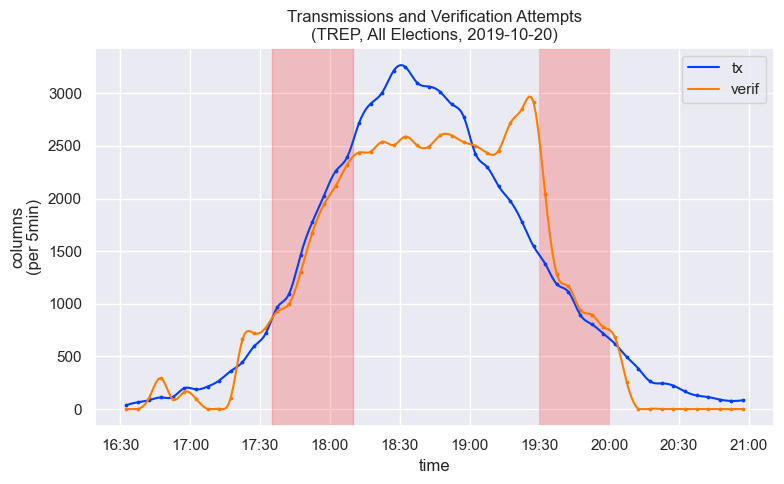

In [2]:
# drop unwanted events, define what step in the process each remaining event is from.
trep = trep.drop(index=trep[trep.evt_type == 'aprob'].index) # don't care about approvals (other process).
trep['process'] = trep.evt_type.where(trep.evt_type == 'tx', 'verif') # two different processes (steps) in the vote count. tx=golpe1, verif=golpe2.

# put tx/verif events in 5-min bins. (important note: 'verif' means verif attempts. most succeed but some fail; i'm interested in both, as analysis is procedural)
events = trep \
    .groupby([pd.Grouper(freq='5min', key='evt_time'), 'process']) \
    .size().unstack(level=1) \
    .resample('5min').asfreq().fillna(0) \
    .pipe(lambda x: x.set_index(x.index + pd.Timedelta('2.5min'))) \
    ['2019-10-20 16:30':'2019-10-20 21:00'] # just election night.
# note: pushed the points to the middle of 5-min bin intervals.

# graph the events.
fig, ax = plt.subplots(figsize=(8, 5), tight_layout=True)
ax.set_title('Transmissions and Verification Attempts\n(TREP, All Elections, 2019-10-20)')
ax.set_xlabel('time')
ax.set_ylabel('columns\n(per 5min)')
smooth_lines_scatter(events, ax, interval='1min', labels=['tx', 'verif'])
add_high_traffic_bars(ax)
ax.xaxis.set_major_formatter(hhmm_format)
ax.legend()
if save_results:
    plt.savefig(path_join('out', '01-tx-verif.png'), dpi=200)

<figure>
    <center>
        <figcaption style="font-size: 75%">Vertical spans are the high-traffic periods. (Note: In the main text, I cite 19:32 as the start of the second high-traffic event, since that's when 'verif' crashes if you use 1-minute bins.)</figcaption>
    </center>
</figure>

If acta column shortages caused verification operators to aggressively poll the application server, then I might also expect that, when verifiers appear to work slower, their traffic rate will increase because they've started to repeatedly ask the application server for work instead of actually working. To check this, first I calculated verifiers’ work rate in 5-minute intervals, taking the number of verification attempts and dividing it by the number of active verifiers. Next, I extracted the data points from EHC's traffic graph and divided bo1’s traffic (=verifs) by bo11’s traffic (=transmits) to create a simple metric that shows when bo1's traffic was unusually high relative to the general level of activity in the system. Finally, I plotted the two ratios against each other. The resulting graph confirms the prediction that decreases in verifiers’ work rate coincide with increases in their traffic rate:

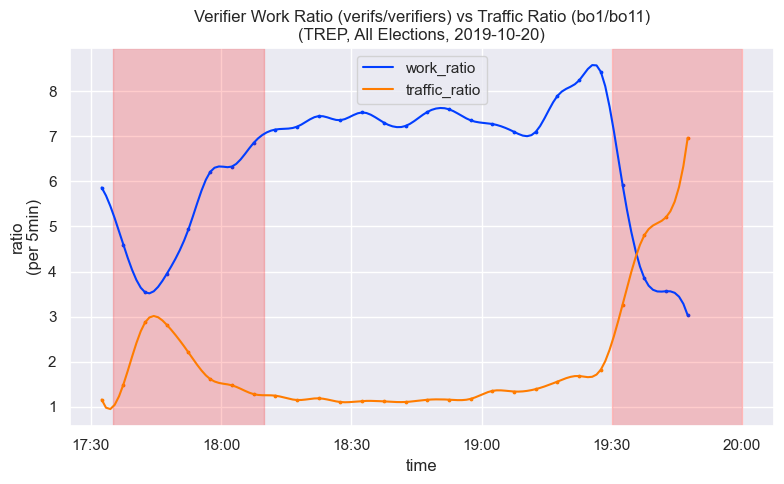

In [3]:
wt = trep[trep.process == 'verif'] \
    .resample('5min', on='evt_time') \
    .pipe(lambda x: pd.DataFrame({'verifs': x.size(), 'verifiers': x.VerificadorUser.nunique()})) \
    .join(traffic, how='inner') \
    .pipe(lambda x: x.set_index(x.index + pd.Timedelta('2.5min'))) \
    ['2019-10-20 16:00':'2019-10-20 20:30'] # just election night.
# note: pushed the points to the middle of 5-min bin intervals.

# calculate ratios.
wt['work_ratio'] = np.where(wt.verifs > 0, wt.verifs / wt.verifiers, 0)
wt['traffic_ratio'] = np.where(wt.ehc_bo11 > 0, wt.ehc_bo1 / wt.ehc_bo11, 0)

# graph work_ratio (=verifs/verifiers) vs traffic_ratio (=bo1/bo11).
fig, ax = plt.subplots(figsize=(8, 5), tight_layout=True)
ax.set_title('Verifier Work Ratio (verifs/verifiers) vs Traffic Ratio (bo1/bo11)\n(TREP, All Elections, 2019-10-20)')
ax.set_xlabel('time')
# note: i stopped traffic before 19:50 because ehc's data for 19:50 onward seems super incorrect (comparing to bisite's bo1 numbers).
smooth_lines_scatter(wt[wt.index < '2019-10-20 19:50'], ax, interval='1min', labels=['work_ratio', 'traffic_ratio'])
ax.set_ylabel('ratio\n(per 5min)')
add_high_traffic_bars(ax)
ax.xaxis.set_major_formatter(hhmm_format)
ax.legend()
if save_results:
    plt.savefig(path_join('out', '02-work-traffic.png'), dpi=200)

<figure>
    <center>
        <figcaption style="font-size: 75%">I cut it off right before 19:50 because that's when EHC's data stops lining up with BISITE's data. Again, I'm fairly sure EHC's monitoring software started to choke between 19:50-19:55.</figcaption>
    </center>
</figure>

The graphical evidence is highly consistent with polling-driven traffic increases, but it’s also important to analyze the specific HTTP requests behind the traffic increases. However, I don’t have the HTTP logs, so I have to rely on what’s in the IT reports. The BISITE audit said the traffic increases were due to requests for acta verifications (BISITE, p91), which EHC and NEOTEC also indicated in their 2019 reports. The BISITE auditors didn’t specify the exact name of the requests behind the increases, but at the start of that section of their report (BISITE, p69), they defined acta verification requests as ones to the endpoint <code>/process/VerificaActa/VerificaProxima</code> (=<code>/process/VerifyActa/VerifyNext</code>), whose name is suggestive of a polling mechanism. BISITE's findings match EHC's private report, which contains a <a href="https://images2.imgbox.com/5c/7e/OdYfiUQ2_o.jpg">log fragment</a> from the start of the second high-traffic period in which most of the listed requests from bo1 to bo2 were these same VerificaProxima requests. The findings also align with the OAS audit, which cited VerificaProxima as, by far, bo1's most common request to bo2:

<figure>
    <center>
        <img src="./data/imgs/post-imgs/05-oas-http-frequency.png" height="60%" width="60%">
        <figcaption style="font-size: 75%">Warning: This chart excludes a lot of important and common HTTP requests from bo1 to bo2. To create the chart, all the OAS did was exact-match the request URLs, so they only captured a bunch of POSTs with identical URLs.</figcaption>
    </center>
</figure>

So, traffic increased when verification operators started to send more and more of an HTTP request named VerificaProxima, which seems to be a request for an acta column to transcribe. But how *exactly* did VerificaProxima work? Well, I think I know. A week and a half before the election, there were two public demos of the TREP before political representatives, journalists, and other interested observers. During the <a href="https://youtu.be/BtI4_d29HnA?t=1650">first demo</a>, Marcel Guzmán de Rojas transcribed sample acta columns, showing the process from the perspective of the verification operator. In video of the event, he's presented with an acta image and text boxes for his transcription. He transcribes the vote totals from the appropriate column on the acta, then clicks a check-mark box to submit his transcription:

<figure>
    <center>
        <img src="./data/imgs/post-imgs/06-trep-demo-click.png"/>
    </center>
</figure>

His transcription matches the one that's already on the application server, so the acta image and text boxes vanish and a new button appears:

<figure>
    <center>
        <img src="./data/imgs/post-imgs/07-trep-demo-verificaproxima-wide.png"/>
        <img src="./data/imgs/post-imgs/08-trep-demo-verificaproxima-close.png" height="60%" width="60%"/>
        <figcaption style="font-size: 75%">Clicking ’Verifica próxima’ causes the client's browser to ask the server for another acta column to transcribe.</figcaption>
    </center>
</figure>

It's a bit hard to read, but the button says '<a href="https://youtu.be/zwEyZ6hIzzY?t=985">Verifica próxima</a>'. This button is the source of the VerificaProxima HTTP requests that were responsible for the high-traffic events. Each time a verifier clicked the ‘Verifica próxima’ button, their browser sent a VerificaProxima HTTP request to bo2 (via bo1). Therefore, increases in the rate of VerificaProxima requests actually reflect increases in the rate of ‘Verifica próxima’ clicks. Given this, the question about the high traffic can be reframed: What caused verifiers to start clicking 'Verifica próxima' more and more?

To answer that, it’s helpful to observe the verification process in a <a href="https://youtu.be/sn7Zna00l7I">loop</a>:

<center>
    <video controls src="./data/vids/verif-video.mp4"/>
</center>
<center>
    <figure>
        <figcaption style="font-size: 75%">During transcriptions, there are three buttons: ‘✓' (=[Submit]), ‘x’ (=[Reject]), and ‘Invierte imagen' (=Invert image). Below those buttons are three text fields: 'Mesa' (=Polling station ID), 'Elección' (=Election type; ie. which column to transcribe), and 'Inscritos' (=Registered voters). If the user submits transcription that doesn’t match, then a '✓ con diferencias' (=[Submit] with differences) button appears too. However, between transcriptions, there's only one labeled button: 'Verifica próxima'.</figcaption>
    </figure>
</center>

After the video's final transcription, Marcel Guzmán de Rojas clicks 'Verifica próxima' like before but instead of receiving another acta column to transcribe, a red warning message pops up:

<figure>
    <center>
        <img src="./data/imgs/post-imgs/09-trep-demo-red-warning.png"/>
        <figcaption style="font-size: 75%">A red warning message, the result of a 'no columns' response to a VerificaProxima request after the demo’s application server ran out of verification-elegible acta columns. (Note: The cursor is on the out-of-frame 'Verifica próxima' button. The object in the middle of the screen is a visual artifact that appears after a completed transcription, as can be seen at 0:20 of the video, for example.)</figcaption>
    </center>
</figure>

This red warning message appears on a verifier's screen when they click 'Verifica próxima' but get a 'no columns' response from the application server instead of a column to transcribe. I know this partly from context clues (*"¡Listo!"*), but also because, at <a href="https://youtu.be/BtI4_d29HnA?t=2158s">another point</a> in the same demo, Marcel Guzmán de Rojas presses the ‘Verifica próxima‘ button, a red warning message appears, and then he declares, *"No tengo actas. Ahorita van a llegar"* (="I have no actas. They'll arrive in a moment"). The warning is also visible in a photo from the OAS's 2019/2020 EOM report. It reads, *“No quedan actas para verificar. Revise nuevamente en 1 minuto”* (="There are no actas left to verify. Check again in 1 minute"):

<figure>
    <center>
        <img src="./data/imgs/post-imgs/10-oas-red-warning.png" height="60%" width="60%" />
        <figcaption style="font-size: 75%">Photo taken by an OAS observer at the SERECI offices on Election Night after the SERECI's internet was cut, which is why all the other warning messages have to do with internet problems. Also, an observation: The lights are still on in the background, so I don’t know what to make of claims that the SERECI’s power was cut too. (Source: OAS 2019/2020 EOM Report, p73)</figcaption>
    </center>
</figure>

So, when the verification operator clicked the 'Verifica próxima' button, their browser sent a VerificaProxima HTTP request to bo2 (via bo1). When bo2 had columns for them to transcribe, clicking 'Verifica próxima' got the user another one, but when bo2 didn't have any columns to transcribe, clicking it got them the red warning message. A verifier who received a column would've spent, on average, about 40 seconds transcribing it before clicking 'Verifica próxima' again, but one who received the warning message would've continued to click 'Verifica próxima' in anticipation of new columns becoming available, ignoring the instruction to wait a minute before clicking again. On Election Night, traffic began to spike once users encountered an acta shortage because the shortage caused the warning message to start to appear, so users went from calmly clicking ‘Verifica próxima’ once every 40 seconds to impatiently clicking it over and over, with each click causing their browser to send an HTTP request to bo2 (via bo1). As the shortage worsened, users saw the warning more and more often, so they clicked ’Verifica próxima’ more and more, until eventually the shortage abated, the users backed off, or, as occurred on Election Night, someone disrupted their internet connection.

There’s a basic sanity test you can run on this interpretation. The BISITE audit reported that, between 17:30 and 20:00, the max number of ‘verification’ (=VerificaProxima) requests from bo1 to bo2 in a 5-minute period was 25,764 requests between 19:55-20:00 (BISITE, p91). There were 350 verification operators, so at their peak each verifier would've clicked the 'Verifica próxima' button once every 4.08 seconds on average, which sounds plausible to me.

Finally, this increase in HTTP traffic was *totally normal*. In the 2019 TREP, periods of high HTTP traffic perfectly coincide with periods of persistent ‘transmit_rate ≈ verif_rate', so it's reasonable to expect ‘transmit_rate ≈ verif_rate' to be a good proxy for high traffic in other TREPs conducted with the same software. With that in mind, have a look at NEOTEC's 2019/2017 TREP comparison again:

<figure>
    <center>
        <img src="./data/imgs/post-imgs/03-neotec-2017-2019.png" height="60%" width="60%"/>
        <figcaption style="font-size: 75%">Notice how ∫ tx - verif, (while tx > verif) ≈ ∫ verif - tx, (while verif > tx)? That's the backlog being built up, then drawn down.</figcaption>
    </center>
</figure>

Both elections have the same ‘transmit_rate ≈ verif_rate' periods: One at the start when verifiers matched the initial ramp-up in transmits and one at the end after verifiers exhausted the backlog that had built up. The second ‘transmit_rate ≈ verif_rate' period in 2017 surely coincided with a traffic spike similar to the one that sparked the 2019 crisis, but in 2017 it came and went without incident.

## Other Explanations ##

There were two accounts of the traffic increase from direct participants. One came from EHC's CEO Alvaro Andrade, whose private report to the TSE said that before the press conference, the TSE asked NEOTEC for a private look at the TREP results and, to comply with this request, NEOTEC sent results to the bo1 server, which housed not only an nginx reverse proxy but also <a href="https://images2.imgbox.com/db/bd/b5nydVzg_o.png">databases</a> with a mix of historical and test data and a Tomcat/SIMOBOL server to view that data. This version from EHC is a bit different from their later public report, which also pointed to the preview but said the spike was due to a redirection of verification traffic. On Election Night, Guzmán de Rojas must’ve reflexively told Andrade and others that the increase was due to results traffic from the preview, but Andrade rejected this because his firm monitored that traffic and knew the requests were for verifications. In EHC’s public report, Andrade tried to mash the two explanations together, conflating results traffic with verification traffic and claiming the latter had been ‘redirected’.

The other account came from TSE Vice President Antonio Costas, whose explanation shares elements with the accounts in EHC's reports. In press interviews after his resignation, Costas said the traffic increase was related to his colleagues' request to preview the results, with Costas specifically identifying the migration of electoral data from bo2 to bo1 as the cause. For example, in his Unitel <a href="https://youtu.be/b7LoxDrBJk8?t=199">interview</a>, Costas said *'se migró una parte de los datos para publicarlos a otro servidor'*. (='Part of the data was migrated in order to publish it to another server.') Likewise, in his CNN <a href="https://youtu.be/TKA3HwFGLhk?t=1361">interview</a>, Costas said, *'se hizo una migración hacia un reservorio, hacia un servidor que no estaba contemplado en el área de información que estaba controlada.'* (='There was a migration to a (data) reservoir, to a server [bo1] that wasn't part of the controlled IT infrastructure.') That is, some TREP data was copied from bo2 to bo1 to allow his colleagues to preview the election results, and this is what caused the traffic increase.

None of these are correct, though. First, the BISITE audit indicates that the HTTP spikes were driven by verification traffic, not results traffic. Specifically, results traffic was only 0.91% of bo1's requests to bo2 between 17:30-20:00 (BISITE, p91). Second, verification requests weren’t redirected from another source because bo1 was the only source of ‘verification’ traffic on Election Day (BISITE, whole report). Furthermore, if the increase were due to the redirection of verification traffic or the migration of election results, then you might expect a sudden, one-time traffic jump, not steady traffic increases over 20 minutes or so, which are better explained by verifiers clicking 'Verifica próxima' more and more as slack in the verification process increased. Lastly, all their explanations are specific to the traffic increase at 19:30 and can't explain a similar event two hours earlier.

## The Limits of the ActaLog Data ##

(Note: If you want to understand this section, you should probably read <a href="https://www.reddit.com/user/srslyjuststop/comments/rl7m4u/guide_to_the_2019_trep_actalog/">this</a> first.)

I'm certain that the explanation I gave is correct, but there was one test I ran that didn’t give me the results I expected. In the description I gave, it's helpful to think of bo2's unprocessed acta columns as a sort of pool. This pool grows with acta column transmissions but shrinks with verification attempts. HTTP traffic spikes occur when the pool is empty and no columns are available for verifiers to transcribe, so the verifiers ask the application server for work over and over. To test this interpretation, I took the data from bo2's ActaLog and tracked the status of each acta column over the course of the count under the assumption that, in a given moment, the pool is the set of acta columns that have recorded a transmission but no verification attempt.

So, an acta column should enter the pool at:

<code>enter_pool = actalog.first_transmit</code>

And leave the pool at:

<code>exit_pool = actalog.verif_attempt</code>

During traffic spikes, the number of columns in the pool should be effectively zero. But when I checked, it wasn't zero:

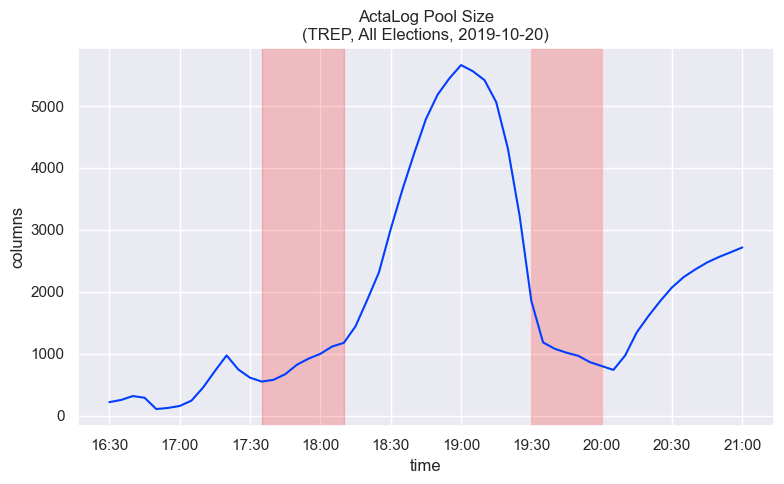

In [4]:
# calculate pool. (using closed interval)
pool = trep \
    .drop_duplicates(subset=['col_id', 'process'], keep='first') \
    .groupby(['evt_time', 'process']) \
    .size().unstack(level=1).fillna(0) \
    .pipe(lambda x: x.tx.cumsum() - x.verif.cumsum()) \
    .resample('5min').ffill().fillna(0) \
    ['2019-10-20 16:30':'2019-10-20 21:00']

# graph pool
fig, ax = plt.subplots(figsize=(8, 5), tight_layout=True)
ax.set_title('ActaLog Pool Size\n(TREP, All Elections, 2019-10-20)')
ax.set_xlabel('time')
ax.set_ylabel('columns')
ax.plot(pool, label='pool')
add_high_traffic_bars(ax)
ax.xaxis.set_major_formatter(hhmm_format)
if save_results:
    plt.savefig(path_join('out', '03-pool-actalog.png'), dpi=200)

When the traffic spikes occur, the surplus pool is low in relative terms, but it’s still around 1000 columns, not zero, and the number of such columns slowly increases or decreases depending on the moment. Despite this, I have no doubts about the VerificaProxima polling interpretation. There’s far too much evidence to support it. So, I figure my definition of the surplus pool is too broad. For the graph above, I counted all acta columns with a transmission but no verification attempt according to bo2’s ActaLog, but evidently there was more to it than that. So, how did VerificaProxima define which columns were eligible for verification?

To start, I think it's reasonable to assume VerificaProxima would've only picked an acta column for verification if the server's database had the basic elements needed to attempt a verification. At minimum, this would mean: 1) an acta image to transcribe, and 2) an initial transcription to compare against the verifier’s transcription. You might think that if the server's database had the initial transcription, then it must‘ve had a photo too, but that’s not true. The two were separate, which is evident from a screenshot on the TREP mobile app's <a href="https://play.google.com/store/apps/details?id=com.guzral.simoregacta">Google Play page</a> ('TR/TRImg'). It’s just that in the TREP, unlike the Cómputo, the same user was responsible for recording and sending both the initial transcription *and* the acta image. The initial transcriptions were sent to bo2 (via bo11) as *registroActa* requests (BISITE, p69) and stored in the Acta table (BISITE, p164; ActaLog can be used to reconstruct Acta), whereas the acta images were sent to bo2 (via bo11) as *registroImagenActa* requests and stored in the ActaImagenLog table, which I don't have at all. (Note: BISITE also mentions an ActaImagenError table.) That's a serious problem. An acta column that appears to be verification-eligible based on the Acta table might have a missing or invalid record in the ActaImagen tables, so VerificaProxima would skip over it.

There’s evidence that VerificaProxima really did enforce this condition. While I don’t have SIMOBOL‘s source code, there’s a revealing snippet of it visible in EHC’s report:

<figure>
    <center>
        <img src="./data/imgs/post-imgs/11-ehc-catalina-log.png" />
        <figcaption style="font-size: 75%">Entries are in reverse chronological order. (Source: EHC Public Report, p34)</figcaption>
    </center>
</figure>

In the Tomcat log above, there's a JDBC exception caused by a malformed SQL statement that the application server tried to execute while processing a request called ComputoProxima, which is a Cómputo-specific variant of VerificaProxima. The visible fragment of the bad SQL statement indicates that when ComputoProxima (and VerificaProxima) picked acta columns for verification, this involved selecting records with verification-eligible status values from the Acta table (aliased as 'a') and matching them by polling station ID against the records in the ActaImagenLog table. In other words, VerificaProxima selected acta columns that had both a transcription **and** an image. I only have the Acta table (as ActaLog), so all I can do is track whether an acta column had a transcription available, not whether it had an image too, which would require ActaImagenLog (and perhaps ActaImagenError as well).

Without the ActaImagenLog table, I'm at a dead end. But let's pretend I do have it.

Now, an acta column would enter the pool at:

<code>enter_pool = max(actalog.first_transmit, actaimagenlog.first_transmit)</code>

And leave the pool at:

<code>exit_pool = actalog.verif_attempt</code>

But that's still not quite right. It should exit the pool *when it gets served to a verification operator*, not when the verifier's transcription was completed (<code>actalog.verif_attempt</code>). It makes sense that a column exited the pool once it was served to a verifier because if a verifier were transcribing a column, then serving that same column to another verifier would needlessly duplicate work. What's more, if a column being transcribed by one verifier were still eligible to be served out to other verifiers, then you would only see 'Verifica próxima' click-spam in the extreme case in which all verifiers were idle and there was no work available for anyone. I know this didn't occur on Election Night, though, as the ActaLog data shows verifiers submitted transcriptions to bo2 continuously from 17:30 to 20:07, save two brief moments around 20:00 due to internet issues at the SERECI offices.

Without this 'served' data, I'm at a dead end (again). But let's pretend I do have it (and it exists).

An acta column would enter the pool at:

<code>enter_pool = max(actalog.first_transmit, actaimagenlog.first_transmit)</code>

And leave the pool at:

<code>exit_pool = somelog.served</code>

But that's not quite right either. In a <a href="https://youtu.be/zwEyZ6hIzzY?t=104">pre-election workshop</a>, the SERECI director said they had a "call center" which provided assistance to transmission operators and was responsible for phoning those who hadn't sent an acta photo or had sent an "invalid" one and telling them to send a new photo. If an acta image was marked as invalid, it almost certainly was ineligible to be served to a verification operator, so that's yet another constraint to evaluate, but, like so many other ones, I don't have the data to evaluate it.

The inescapable conclusion here is that I can't do this calculation. In fact, I'm not sure it's even possible to do it. I still did my best to address it, though, because I ran the basic form of this test and it failed. Others might also run that test and it'll fail for them too. It fails because it assumes that eligibility begins when a transcription is on the server and ends when a verifier's transcription is recorded, but in fact eligibility begins when a transcription *and* an image are on the server (the image arrives second, so in practice this condition is: when an image is on the server) and ends when the column is served out to a verification operator, plus some lesser conditions. It *might* be possible to do this with bo2's full database and SIMOBOL's source code, but not without them. There was an earlier version of the analysis where I used a trick to estimate a subset of bo2's ActaImagenLog table and succeeded in eliminating most (but not all) of the acta columns in the surplus pool, but I think that approach was a mistake. You either have the data to do the calculation or you don't, and I simply don't.

Fortunately, I don't need that calculation to show there was a shortage. The fact that verif_rate shadows transmit_rate throughout both high-traffic periods is strong evidence of a supply constraint (ie. there was a shortage). So, as far as I’m concerned, the ‘Verifica próxima’ explanation here isn’t just some theory but an established fact about what occurred. It should be better-known since it was the <a href="https://eldeber.com.bo/usted-elige/30000-solicitudes-de-validacion-alertaron-sobre-el-fraude-en-las-elecciones-de-2019_203594"><i>detonante</i></a> of the mess on Election Night, but I doubt it’ll ever be repeated outside of my posts.

# Additional Analysis #

A few points and observations that I couldn't fit in the post.

### Excess VerificaProxima Requests ###

Earlier I said, "The excess requests [during the high-traffic periods] are actually verification operators' unsuccessful requests for acta columns to transcribe."

When columns are available for verification, VerificaProxima and verification attempts should be roughly equal, since the user clicks 'Verifica próxima' once, then transcribes the acta column they receive. However, during shortages, the user clicks 'Verifica próxima' multiple times to get an acta column, so there will be 'excess' VerificaProxima requests.

So, I'll calculate:

<code>excess = verificaproxima - verif_attempts</code>

It should be around zero in non-shortage periods, but > 0 in shortage periods.

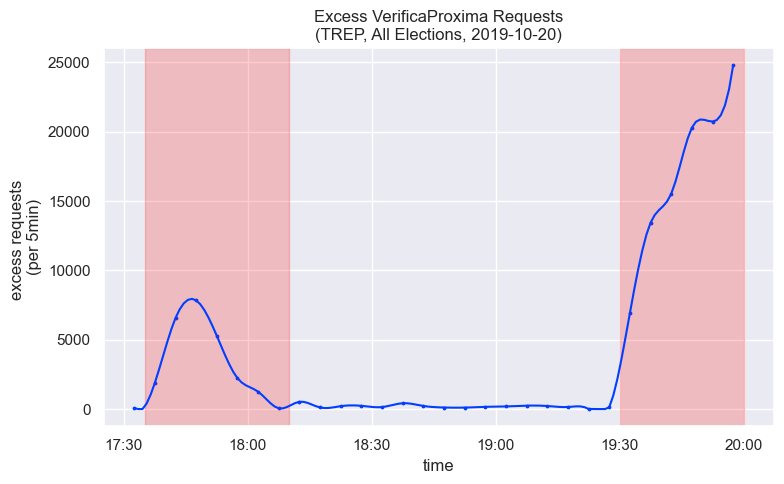

In [5]:
# note: bisite_bo1_verif is bisite's 'verification' (=VerificaProxima) requests. (values extracted visually, so they're only approximate)
excess = traffic.set_index(traffic.index+pd.Timedelta('2.5min')) \
    .pipe(lambda x: pd.DataFrame({'excess': x.bisite_bo1_verif - events.verif})) \
    .dropna()
# had to shift traffic's index forward 2.5min to mid-bin so it'll match 'events' which already had indices moved to mid-bin.

# graph the events.
fig, ax = plt.subplots(figsize=(8, 5), tight_layout=True)
ax.set_title("Excess VerificaProxima Requests\n(TREP, All Elections, 2019-10-20)")
ax.set_xlabel('time')
ax.set_ylabel('excess requests \n(per 5min)')
smooth_lines_scatter(excess, ax, interval='1min', labels=['excess'], lo_clip=0) # lowest real val is, like, 7. clip is just avoiding interpolated vals below 0.
add_high_traffic_bars(ax)
ax.xaxis.set_major_formatter(hhmm_format)

👍 (Maybe I should've ended Period #1 a bit earlier?)

Another look at the clicking patterns:

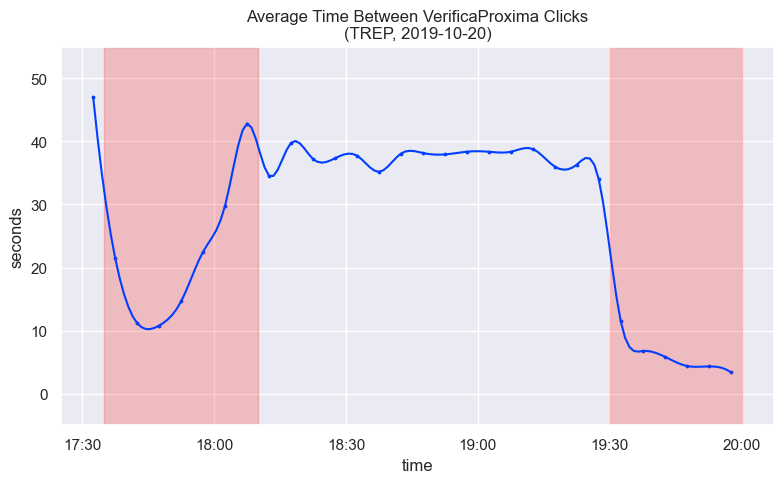

In [6]:
# average click rate per user.
fig, ax = plt.subplots(figsize=(8, 5), tight_layout=True)
ax.set_title("Average Time Between VerificaProxima Clicks\n(TREP, 2019-10-20)")
ax.set_xlabel('time')
ax.set_ylabel('seconds')
click_rate = wt[wt.bisite_bo1_verif.notna()].pipe(lambda x: pd.DataFrame({'click_rate': 300 / (x.bisite_bo1_verif / x.verifiers)})) # 5min=300sec
smooth_lines_scatter(click_rate, ax, interval='1min', labels=['click_rate'])
ax.set_ylim([-5, 55])
add_high_traffic_bars(ax)
ax.xaxis.set_major_formatter(hhmm_format)

👍 (Again, maybe I should've ended Period #1 at 18:05. My idea with 18:10 was that it seemed like 18:05-18:10 was where the traffic rate finally bottomed out in EHC's graph.)

### 'Verification' Requests ###

BISITE's audit defines 'verification' requests as just VerificaProxima (BISITE, p69), but VerificaProxima wasn't even how verification users submitted transcriptions. When a verification operator clicked the ‘✓' (=[Submit]) button, their browser sent a <code>/process/VerificaActa/editOnView/saveAndList/xxxxxxx</code> request and when they clicked '✓ con diferencias' (=[Submit] with differences), it sent a <code>/process/VerificaActa/editOnView/saveAndListConDif/xxxxxxx</code> request:

<figure>
    <center>
        <img src="./data/imgs/post-imgs/12-fragment-ehc-first-report.jpg" />
        <figcaption style="font-size: 75%">HTTP log fragment from EHC"s private report. Not sure what <code>/process/VerificaActa/list</code> did.</figcaption>
    </center>
</figure>

The BISITE auditors knew VerificaProxima wasn't the request that produced acta verifications, otherwise they wouldn't have described VerificaProxima as "peticiones de información y consultas que no implicaban la modificación de datos", but failing to describe <code>saveAndList</code> and <code>saveAndListConDif</code> as 'verification' requests is a mistake, no?

The miscategorization of requests was a recurring issue. On p24 of the *Sobreseimiento* document, Marcel Guzmán de Rojas complained to authorities:
<blockquote>Andrade dice que son 30 mil verificaciones cada 30 segundos, muy bien que esas entraron por BO1, eso es cierto pero a ver son 34mil 555 actas en otras palabras y cada acta tiene dos pedazos son 70 mil actas eso significa que en un minuto y 10 segundos se hubieran procesado todas estas actas, eso nunca ocurrió, ósea esa alerta que da Andrade que está equivocada y no sé de dónde se saca esos datos, en los datos que ustedes tienen pueden verificar, les puedo mandar el comando que he usado para mirar el log de nginx de bo1 y ustedes pueden contar cuantas son y yo lo hice y 85 mil 165 muy bien cómo da cuenta Andrade, porque Andrade no tenía acceso ethical hacking no tenía acceso a bo1, eso es cierto pero sí a bo2 entonces eso implica que todo lo que pasaba por bo1 terminaba en BO2, ósea el podía con solo ver BO2 podía ver todo, y si se mira el log de nginx, no está en bo2 porque está en bo1 pero el log de tomcat sí está y tomcat reporta 170 mil 329 <strong>clics de que se quiere guardar un acta para verificar</strong>, en tomcat son el doble si se fijan son casi exactamente el doble se hace la operación matemática por que en el tomcat simonel graba dos lineas por cada petición uno cuando la recibe y otra cuando la responde, en la que responde también dice cuanto tiempo se tardó en procesar, lo cual es critico para nosotros, nosotros necesitamos saber si el sistema se está volviendo lento.</blockquote>

Guzmán de Rojas, who wrote SIMOBOL and actually knew how it worked, was probably counting up <code>saveAndList</code>-type requests because *those* are verification attempts, not realizing that Andrade's 'acta verifications' were mostly <code>VerificaProxima</code> requests (and Andrade was citing the wrong interval, causing even more confusion).

### Minute-Specific Start of 2nd High-Traffic Period ###

Earlier I said, "In the main text, I cite 19:32 as the start of the second high-traffic event, since that's when 'verif' crashes if you use 1-minute bins."

If you track the verification trends around 19:30 but use 1-minute bins, you'll see verifications crash at 19:32 and the focus shifts to much newer acta columns.

In [7]:
# (note: the verif crash lags actual onset of high-traffic event slightly since verif times are *completed* verif attempts, but it's fine)
trep['verif_delay'] = (trep.VerificadorDate - trep.PriTransmisionDate).where(trep.process == 'verif', pd.NaT)
percentiles = [0.25, 0.50, 0.75]
trep[(trep.process == 'verif') & (trep.evt_time >= '2019-10-20 19:25') & (trep.evt_time < '2019-10-20 19:40')] \
    .groupby(pd.Grouper(freq='1min', key='evt_time')) \
    .pipe(lambda x: pd.DataFrame({
        'verifs': x.size(),
        'verif_delay_mean': x.verif_delay.mean(numeric_only=False).round('s'),
        **{f'verif_delay_{int(p*100)}%': x.verif_delay.quantile(p).round('s') for p in percentiles}
    })) \
    .style.apply(lambda x: np.where(x.index >= '2019-10-20 19:32:00', 'background-color:yellow', ''))

,verifs,verif_delay_mean,verif_delay_25%,verif_delay_50%,verif_delay_75%
evt_time,,,,,
2019-10-20 19:25:00,603,0 days 00:14:34,0 days 00:00:49,0 days 00:03:37,0 days 00:23:07
2019-10-20 19:26:00,578,0 days 00:18:45,0 days 00:00:55,0 days 00:04:10,0 days 00:36:16
2019-10-20 19:27:00,567,0 days 00:18:14,0 days 00:00:56,0 days 00:04:25,0 days 00:31:55
2019-10-20 19:28:00,583,0 days 00:25:51,0 days 00:01:02,0 days 00:10:48,0 days 00:51:45
2019-10-20 19:29:00,585,0 days 00:29:23,0 days 00:01:12,0 days 00:19:38,0 days 00:59:20
2019-10-20 19:30:00,559,0 days 00:24:50,0 days 00:00:57,0 days 00:06:10,0 days 00:49:15
2019-10-20 19:31:00,591,0 days 00:26:48,0 days 00:01:12,0 days 00:12:33,0 days 00:51:44
2019-10-20 19:32:00,337,0 days 00:10:23,0 days 00:00:43,0 days 00:01:13,0 days 00:04:54
2019-10-20 19:33:00,269,0 days 00:04:33,0 days 00:00:46,0 days 00:01:21,0 days 00:03:23


### EHC's Monitoring Agent Choked ###

Earlier, I said, "[At 19:50] EHC's data stops lining up with BISITE's data. Again, I'm fairly sure EHC's monitoring software started to choke between 19:50-19:55."

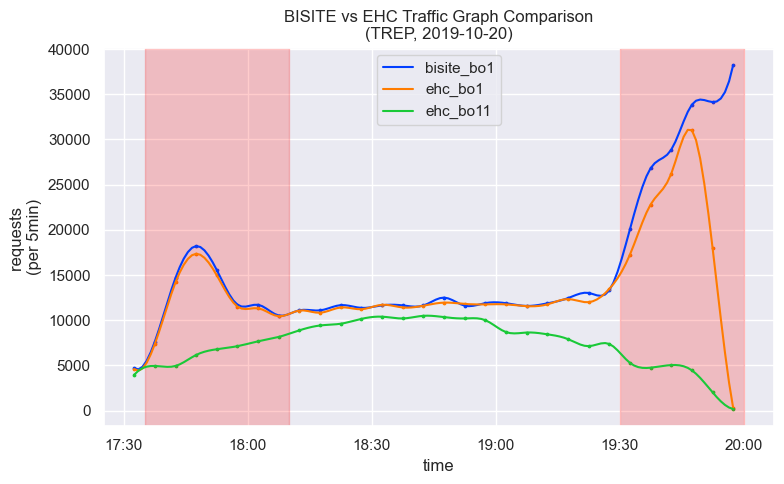

In [8]:
fig, ax = plt.subplots(figsize=(8, 5), tight_layout=True)
ax.set_title("BISITE vs EHC Traffic Graph Comparison\n(TREP, 2019-10-20)")
ax.set_xlabel('time')
ax.set_ylabel('requests \n(per 5min)')
smooth_lines_scatter(wt.dropna(), ax, interval='1min', labels=['bisite_bo1', 'ehc_bo1', 'ehc_bo11'])
add_high_traffic_bars(ax)
ax.xaxis.set_major_formatter(hhmm_format)
ax.legend(loc='upper center')

### The SERECI's Backup Line Activated Eight Minutes Before Their Internet Was Cut ###

Earlier, I identified 200.75.161.30 as the SERECI's backup line and said it was active between 19:58:12 and 20:06:41.

Here is a list of the contiguous periods of IP address usage by users in the basic verification process:

In [9]:
trep[trep.process == 'verif'] \
    .pipe(lambda x: x.groupby((x.VerificadorIP != x.VerificadorIP.shift(1)).cumsum())) \
    .pipe(lambda x: pd.DataFrame({
        'start_time': x.evt_time.min(),
        'end_time': x.evt_time.max(),
        'duration': x.evt_time.max() - x.evt_time.min(),
        'ip': x.VerificadorIP.first(),
        'verif_evts': x.size()
    })).rename_axis('period') \
    .style.apply(lambda x: np.where(x.ip == '200.75.161.30', ['background-color:yellow'] * len(x), [''] * len(x)), axis=1) # highlight the backup line.

,start_time,end_time,duration,ip,verif_evts
period,,,,,
1,2019-10-20 05:21:28,2019-10-20 08:30:15,0 days 03:08:47,186.121.243.162,4
2,2019-10-20 10:00:35,2019-10-20 12:25:35,0 days 02:25:00,190.129.76.2,42
3,2019-10-20 12:35:17,2019-10-20 19:58:07,0 days 07:22:50,186.121.243.162,62759
4,2019-10-20 19:58:12,2019-10-20 20:06:41,0 days 00:08:29,200.75.161.30,1176
5,2019-10-20 20:06:44,2019-10-20 20:07:00,0 days 00:00:16,186.121.243.162,33
6,2019-10-21 10:37:12,2019-10-21 12:29:08,0 days 01:51:56,190.129.76.2,96
7,2019-10-21 14:38:57,2019-10-21 15:13:28,0 days 00:34:31,18.220.48.51,3213


There's good reason to think 200.75.161.30 was the SERECI's redundant backup line. From the OAS audit (p16):
<blockquote>
Se contrató el servicio de internet 100 Mbps Online, que fue proporcionado por la empresa AXS Bolivia. El servicio consiste en un enlace de Fibra óptica entre la empresa AXS y Centro de Datos Primario (San Jorge) del Tribunal Supremo Electoral con servicio de internet 100 Mbps Online exclusivo para el cómputo TREP. La Dirección Nacional de Tecnologías de la Información y la Comunicación (DNTIC) configuró el Servicio de internet AXS 100 Mbps sobre la VLAN 187 red interna del Tribunal Supremo Electoral. (Responsable DNTIC).
<br/><br/>
Por otro lado, el centro de cómputo TREP contó con dos enlaces de fibra óptica, uno activo y el otro pasivo redundante. El primer enlace de fibra óptica instalado desde el Centro de Datos Primario (San Jorge) y el cuarto piso del edificio de Servicio de Registro Cívico La Paz, Switch CORE.
<br/><br/>
El segundo enlace Fibra Óptica (Redundante) provisto por la Empresa MegaLink está instalado hasta el CPD del Servicio de Registro Cívico La Paz con un servicio de internet 100 Mbps. La DNTIC realizó la configuración del servicio de internet mencionado en modo redundante entre un Router perimetral Cisco y el Switch CORE del CPD cuarto piso del edificio del Servicio de Registro Cívico La Paz.</blockquote>

If you do a <a href="https://whois.domaintools.com/">*whois*</a> lookup on the 186.121.243.162 address responsible for most of the verifications, you'll find that it belongs to AXS Bolivia, who the OAS said provided the main line. And if you look up 200.75.161.30, you'll find it belongs to MegaLink, who the OAS says provided the redundant backup line.

One interesting detail that someone might be able to make hay of is the fact that the VerificadorIP value for the acta verifications performed via bo20 on October 21st is 18.220.48.51. This is the IP address of the bo20 server itself, not the SERECI offices. I think it must've been due to some quirk in how things were configured, but I don't *know know* that.

### Regional Verification Spikes ###

In the first NEOTEC report, Marcel Guzmán de Rojas described the process that selected acta columns for verification as random. However, between the two ‘transmit_rate ≈ verif_rate' periods on Election Night, many columns in bo2's backlog appear to have been ineligible for verification for long periods of time and, when they finally were verified, these verifications occurred in unusual patterns. The best-known case of this was a rush of verifications of presidential columns from the department of Santa Cruz:

In [10]:
# utility function for tx-verif plots split by election type. (note: ignoring mid-bin thing.)
elex_aliases = {'Presidente y Vicepresidente': 'prez', 'Diputados Uninominales': 'dip-uni', 'Diputados Especiales': 'dip-esp'}
elex_order = [(e, p) for e in elex_aliases.values() for p in ['tx', 'verif']]
def get_evts_by_elex(df, start='2019-10-20 16:00', end='2019-10-20 21:00', freq='5min'):
    df = df[['evt_time', 'ElecActa', 'process']].copy()
    df['ElecActa'] = df.ElecActa.map(elex_aliases)
    return df \
        .groupby([pd.Grouper(freq=freq, key='evt_time'), 'ElecActa', 'process']) \
        .size().unstack(level=[1, 2]) \
        .resample(freq).asfreq().fillna(0) \
        .pipe(lambda x: x.loc[start:end, sorted(x.columns.to_list(), key=lambda y: elex_order.index(y))]) \
        .rename_axis('time') \
        .rename_axis(['election', 'process'], axis='columns')

<AxesSubplot:title={'center':'Transmissions/Verifications by Election\n(TREP, Santa Cruz, 2019-10-20)'}, xlabel='time', ylabel='columns\n(per 5min)'>

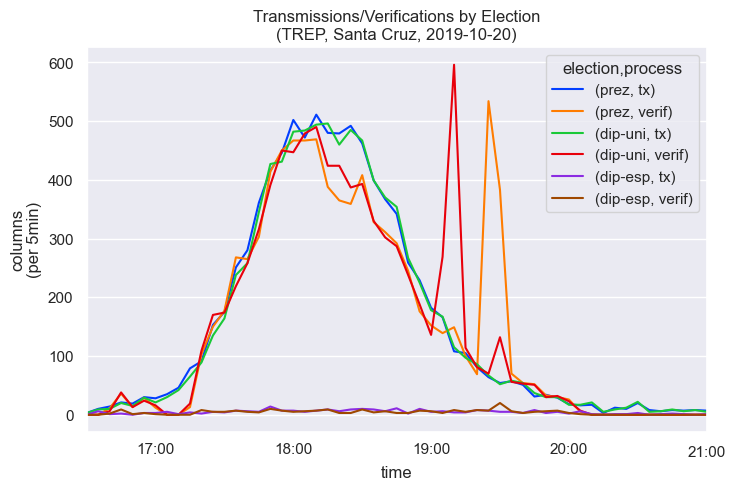

In [11]:
# show santa cruz spikiness.
get_evts_by_elex(trep[trep.Dep == 'Santa Cruz'], start='2019-10-20 16:30').plot(
    title='Transmissions/Verifications by Election\n(TREP, Santa Cruz, 2019-10-20)',
    ylabel='columns\n(per 5min)',
    figsize=(8, 5)
)

In a TV interview, EHC’s Álvaro Andrade cited the orange spike from 19:29-19:32 as the cause of the TSE's 'change in trend', claiming that columns from Santa Cruz had 'started to arrive', but those columns, which only reduced the MAS's lead by half a point, had arrived much earlier. They had been sent to bo2 at times scattered throughout the period in the graph when verifications failed to keep pace with transmissions, which started a few minutes after 18:00. The composition of the spikes is quite striking, too, since each one is specific to the region and to an election type. Furthermore, if you examine in detail the old columns that formed the basis of the verification spikes, you'll find they were processed roughly in ascending order by polling station identifier. This wasn’t limited to Santa Cruz, either. It occurred *everywhere* (even overseas), albeit at different times and in different orders:

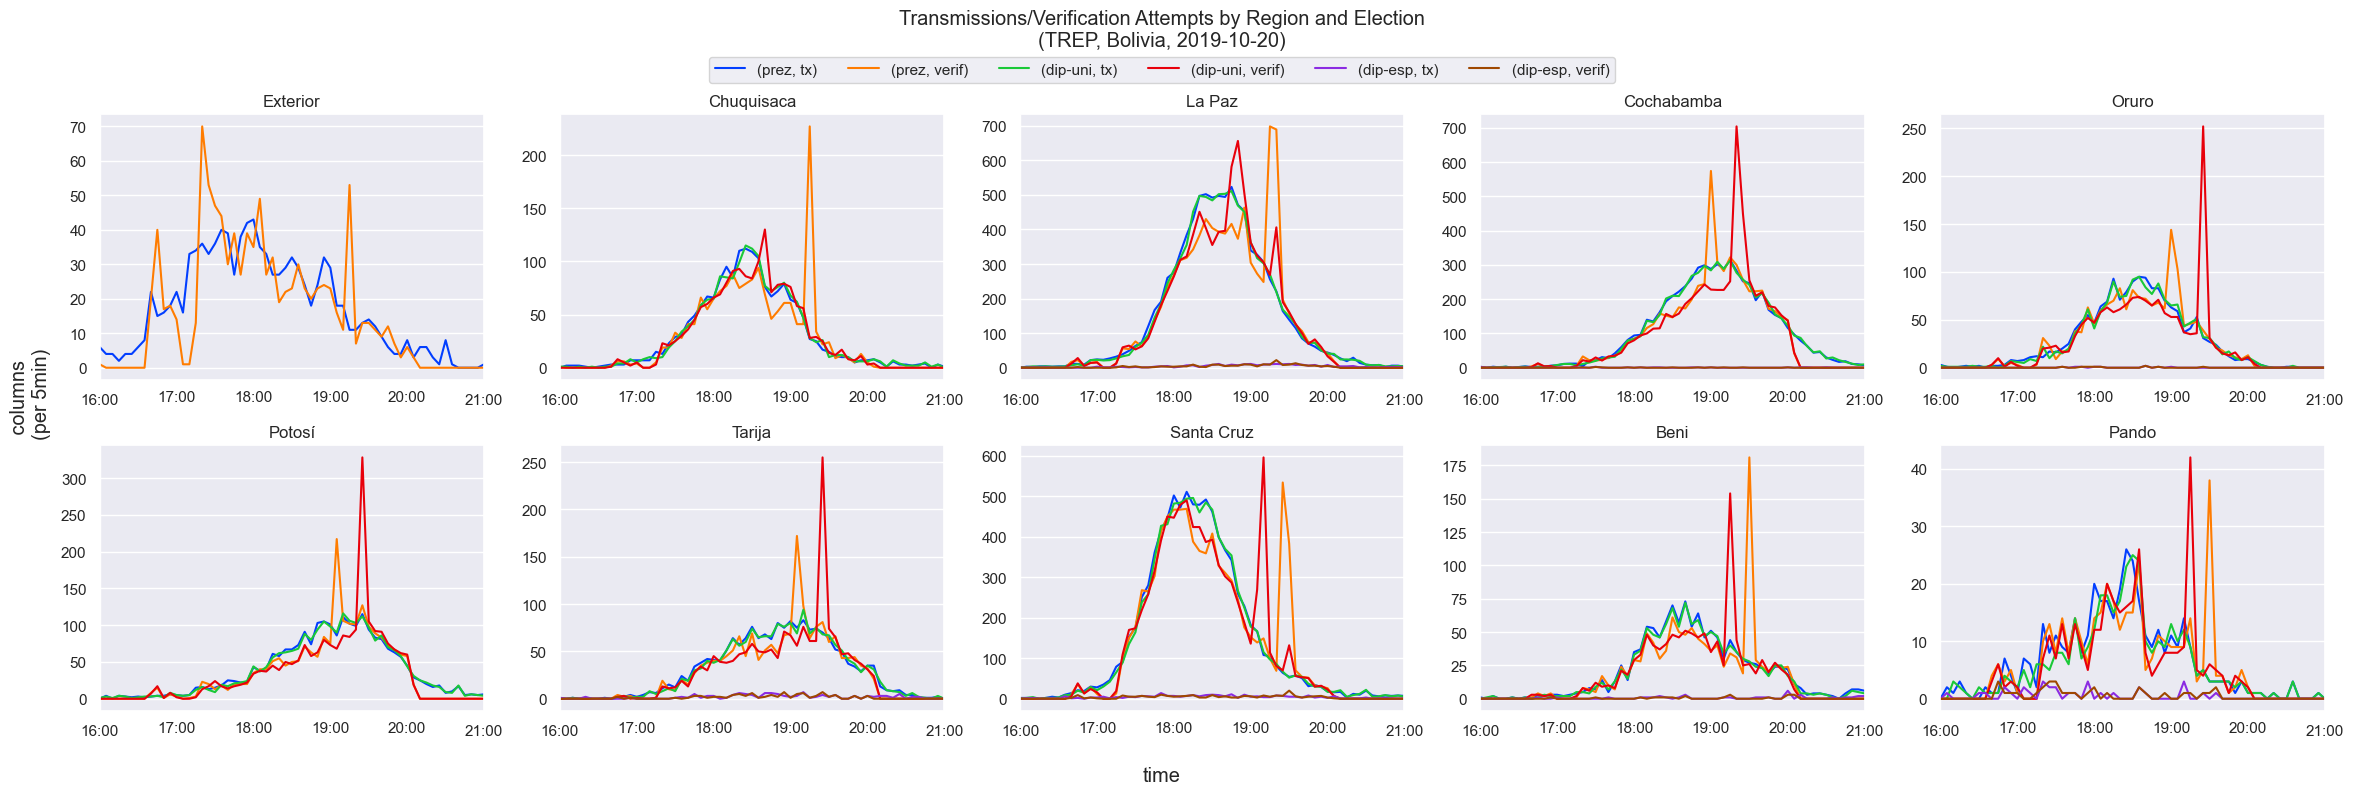

In [12]:
# show all regions
fig, axes = plt.subplots(figsize=(24, 8), nrows=2, ncols=5)
fig.suptitle('Transmissions/Verification Attempts by Region and Election\n(TREP, Bolivia, 2019-10-20)')

# overseas. (note: pre-19:00 overseas spikiness is just because sereci was idle, not actually bottleneck event (which occurs at 19:16-19:17))
get_evts_by_elex(trep[trep.Pais != 'Bolivia']).plot(ax=axes[0,0], title='Exterior', legend=False, xlabel='', ylabel='')

# bolivia
dep_names = trep[trep.Pais == 'Bolivia'].drop_duplicates(subset='Dep').sort_values('NumMesa', ascending=True).Dep.to_list()
for dep_name, ax in zip(dep_names, axes.flat[1:]):
    get_evts_by_elex(trep[trep.Dep == dep_name]).plot(ax=ax, title=dep_name, legend=False, xlabel='', ylabel='')
    
fig.supxlabel('time')
fig.supylabel(' columns\n(per 5min)\n')
fig.legend(
    handles=axes[0, 2].lines, # la paz has all six plot types. (no ordering issues, since all have prez, and no region has special deputy w/o uninominal deputy)
    ncol=len(axes[0, 2].lines), # display all line legends in single row (use la paz again).
    loc='upper center',
    bbox_to_anchor=(0.5, 0.93)
)
fig.tight_layout(rect=(0, 0, 1, 0.97))

<figure>
    <center>
        <figcaption style="font-size: 75%">From roughly 18:50-19:30, VerificaProxima seems to draw columns from *two* sources: 1) new transmits picked at random from all regions, and 2) old transmits picked roughly in ascending order by station ID from a ‘current’ region/election.</figcaption>
    </center>
</figure>

I don't know what caused this, but the patterns in the graph are so sharp and well-organized that I figure they might be the programmatic resolution of some bottleneck, perhaps related to fights for database locks, slow disk writes, or who knows what. I don’t know why they’re organized by region and election either, but when I ran this by someone else, they thought the developer might’ve managed this bottleneck so as to equalize coverage across regions/elections. That’s only one possibility, though. No doubt there are others. There's nowhere near enough information to take a position on this, which seems like the kind of problem for which there’s little alternative to reading the source code. Given that, I’m mostly satisfied with having given a fair top-level description of the behavior.

### During Regional Verification Spikes, Old Actas Were Served Out in Ascending Order by Station ID ###

First, I'll focus on presidential columns processed between 18:00 and 20:00 that had at least 5 minutes between transmission and verification, per the ActaLog data.

In [13]:
# note: you can change the election-type check to (trep.ElecActa == 'Diputados Uninominales') and you'll see the same trend later.
# also, if you flip the delay comparison to: (trep.verif_delay < pd.Timedelta('5min')), the trend will vanish.
old_verifs = trep[
    (trep.process == 'verif') \
    & (trep.ElecActa == 'Presidente y Vicepresidente') \
    & ((trep.evt_time >= '2019-10-20 18:00') & (trep.evt_time < '2019-10-20 20:10')) \
    & (trep.verif_delay >= pd.Timedelta('5min'))
]

Now I'll find each region's peak period of verifications of old acta columns, then plot the station identifiers against the verification times:

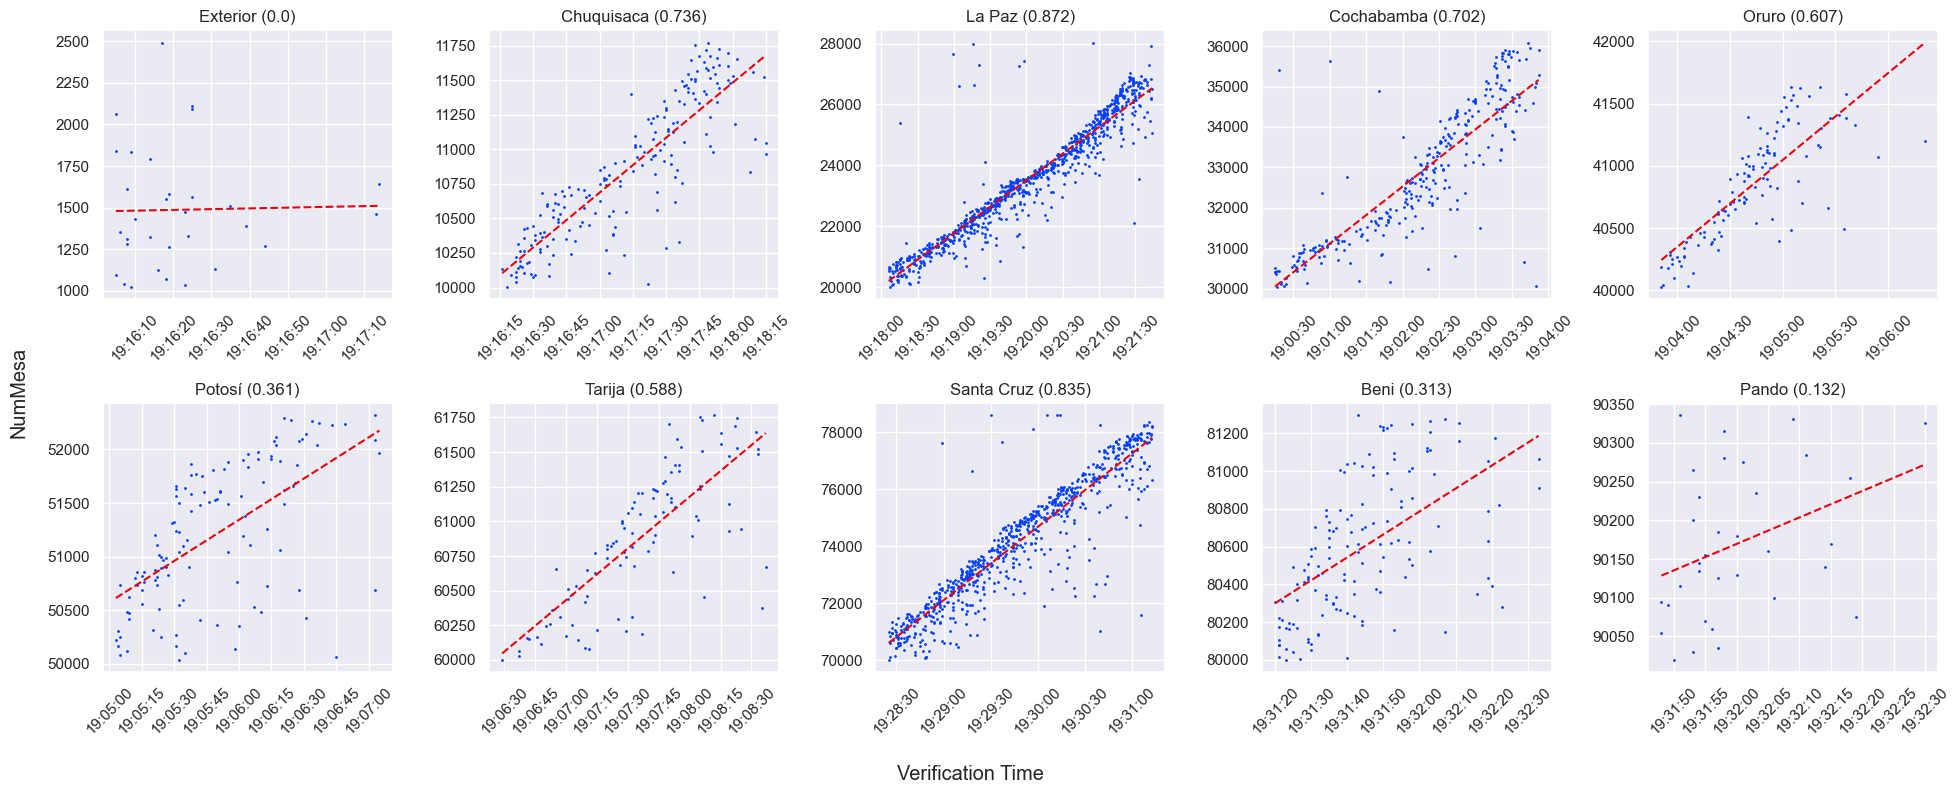

In [14]:
fig, axes = plt.subplots(figsize=(20, 8), nrows=2, ncols=5)

# rough duration of longest regional verification spike.
interval = pd.Timedelta('5min') # if you set this to,say, 120min, the high-verif periods will be evident. (they form very distinct lines)

for region, ax in zip(['Exterior'] + dep_names, axes.flat):
    old_verifs_reg = old_verifs[old_verifs.Pais != 'Bolivia' if region == 'Exterior' else old_verifs.Dep == region]
    if old_verifs_reg.empty:
        ax.set_title(region)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        continue
    
    # find region's peak period for the verification of old actas.
    old_verifs_peak = pd.Series(1, index=old_verifs_reg.evt_time).rolling(interval).count().idxmax()
    old_verifs_slice = old_verifs_reg[old_verifs_reg.evt_time.between(old_verifs_peak - interval, old_verifs_peak)]
    old_verifs_slice = old_verifs_slice[old_verifs_slice.evt_time.between(*old_verifs_slice.evt_time.quantile([0.05, 0.95]))] # trim a bit.
    ax.scatter(old_verifs_slice.evt_time, old_verifs_slice.NumMesa, s=1)
    
    # show linear trend.
    evt_times = old_verifs_slice.evt_time.values.astype(np.int64).reshape(-1, 1) # convert to numeric
    y_pred = LinearRegression().fit(evt_times, old_verifs_slice.NumMesa).predict(evt_times)
    ax.plot(old_verifs_slice.evt_time, y_pred, 'r--')
    ax.set_title(f"{region} ({round(r2_score(old_verifs_slice.NumMesa, y_pred), 3)})")
    
    ax.xaxis.set_major_formatter(hhmmss_format)
    for _ in ax.get_xticklabels(): _.set_rotation(45)

fig.supxlabel('Verification Time')
fig.supylabel('NumMesa\n')
fig.tight_layout()

The trend isn't super clean, but I also wouldn't expect it to be, since these acta columns would've only been *served out* in order. They wouldn't have come back in that same order. I tend to discount the importance of the weaker fits that you see in the smaller regions, since a small region's whole range of station identifiers could've been served out almost instantly, so you wouldn't expect to see much of a trend in when they came back. Larger regions like La Paz and Santa Cruz make the trend clearer because they're big enough that verifiers would've needed some time to work through them all. Don't know about the overseas vote, though. It might be different, or it might be the small-region issue.

Also, there's an odd pattern in La Paz:

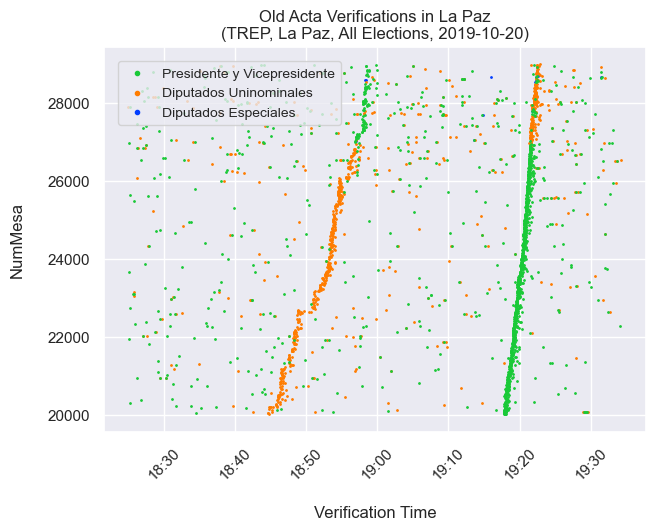

In [15]:
# i noticed an odd pattern in la paz. it's like there's a lower 3/4 of the dept and an upper 1/4 of it.
# in the first verif spike (18:50-ish), you see dip-uni spike on the lower 3/4, THEN prez spikes on the upper 1/4.
# then in the second spike (19:20-ish), it's reversed: prez spikes on the lower 3/4, THEN dip-uni spikes on the upper 1/4.
# what's the split point? does it seem like there's a minicipal/provincial boundary there?
# the serial ordering of the two types of spikes means they're related? not sure!

fig, ax = plt.subplots(figsize=(7, 5))
ax.set_title('Old Acta Verifications in La Paz\n(TREP, La Paz, All Elections, 2019-10-20)')
ax.set_xlabel('\nVerification Time')
ax.set_ylabel('NumMesa\n')
trep[
    (trep.process == 'verif') \
    & (trep.Dep == 'La Paz') \
    & ((trep.evt_time >= '2019-10-20 18:25') & (trep.evt_time < '2019-10-20 19:35')) \
    & (trep.verif_delay >= pd.Timedelta('5min'))
].groupby('ElecActa').apply(lambda x: ax.scatter(x.evt_time, x.NumMesa, s=1, label=x.ElecActa.iloc[0]))
ax.xaxis.set_major_formatter(hhmm_format)
for _ in ax.get_xticklabels(): _.set_rotation(45)
ax.legend(*map(reversed, ax.get_legend_handles_labels()), bbox_to_anchor=(0.45, 0.78), fontsize=10, markerscale=3)